In [2]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
%matplotlib inline

In [3]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 1
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 0
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

ValueError: Invalid RGBA argument: 'l'

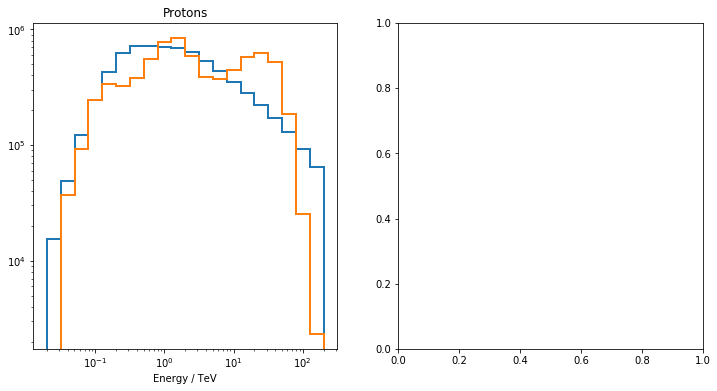

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(protons.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax1.hist(protons.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Protons')
ax1.set_xlabel('Energy / TeV')

ax2.hist(gammas.mc_energy, bins=bin_edges, histtype='step', lw=2, )
ax2.hist(gammas.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Gammas')
ax2.set_xlabel('Energy / TeV')

In [5]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value
protons['theta'] = calculate_theta(protons)
gammas['theta'] = calculate_theta(gammas)

In [6]:
c_bins = np.linspace(0, 1, 10)
c_bin_center = (c_bins[0:-1] + c_bins[1:])/2
c_bin_center

array([0.05555556, 0.16666667, 0.27777778, 0.38888889, 0.5       ,
       0.61111111, 0.72222222, 0.83333333, 0.94444444])

7304127

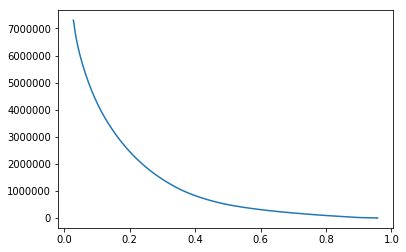

In [19]:
s = protons.gamma_prediction_mean.value_counts().sort_index().cumsum()

plt.step(s.index, s.max() - s, where='post')
len(protons)

In [18]:
s.max()

7304127

In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter


c_bins = np.linspace(0, 1, 20)
c_bin_center = (c_bins[0:-1] + c_bins[1:])/2


def select_data(df, e_low, e_high):
    m = (df.gamma_energy_prediction_mean > e_low )
    m &= (df.gamma_energy_prediction_mean < e_high )
    m &= (df.theta <= 1)
    return df[m] 


for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
    b = select_data(protons, e_low, e_high)
    g = select_data(gammas, e_low, e_high)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title(f'{e_low:0.4f}TeV  -  {e_high:0.4f}TeV')
    ax1.hist(b.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, weights=b.weight, cumulative=-1)
    ax1.hist(g.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, weights=g.weight, cumulative=-1)
    ax1.set_yscale('log')
    
    h, _ = np.histogram(b.gamma_prediction_mean, bins=c_bins, weights=b.weight)
    h = gaussian_filter(h, sigma=1.5)
    h = np.sum(h) - np.cumsum(h)
    ax2.step(c_bin_center, h, where='mid')
    
    spl = interp1d(c_bin_center, h, kind='linear', fill_value='extrapolate')
    xs = np.linspace(0, 1, 200)
    ax2.plot(xs, spl(xs), 'g', lw=3)
    
    h, _ = np.histogram(g.gamma_prediction_mean, bins=c_bins, weights=g.weight)
    h = np.sum(h) - np.cumsum(h)
    ax2.step(c_bin_center, h, where='mid')
#     
    ax2.set_yscale('log')
        
None

/opt/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


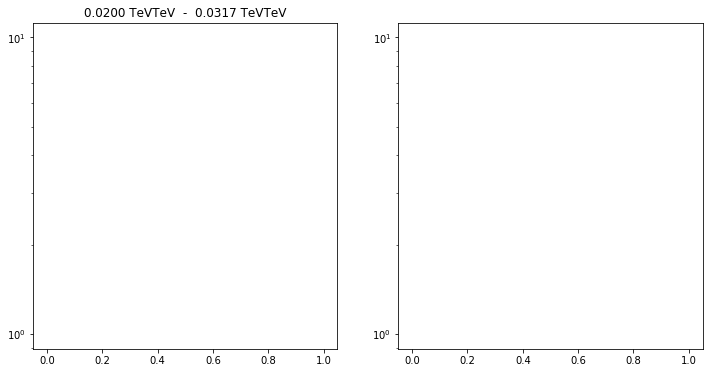

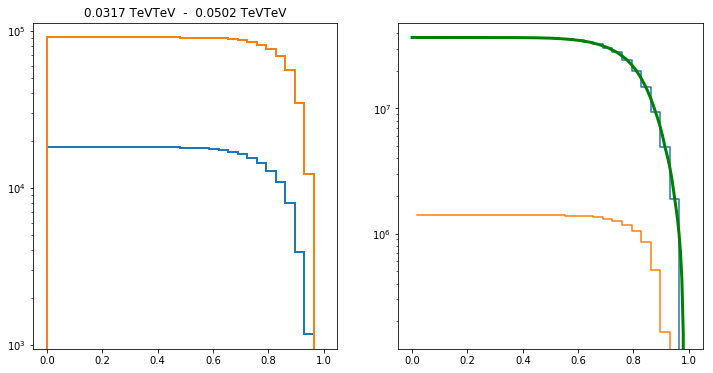

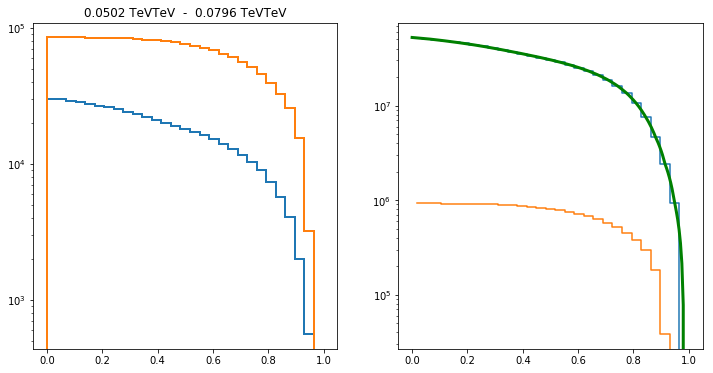

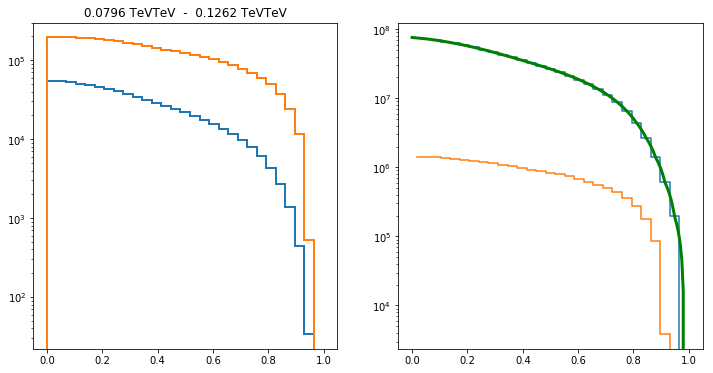

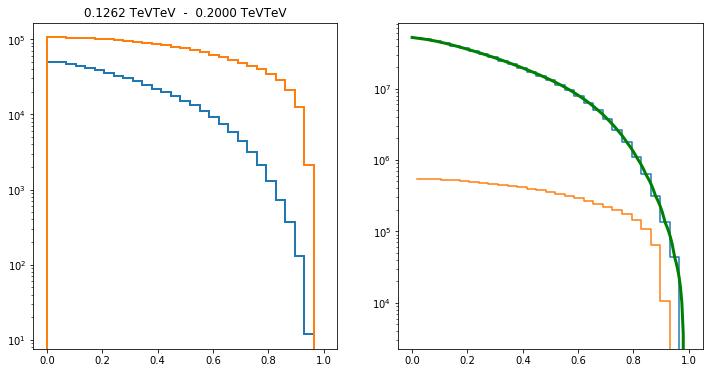

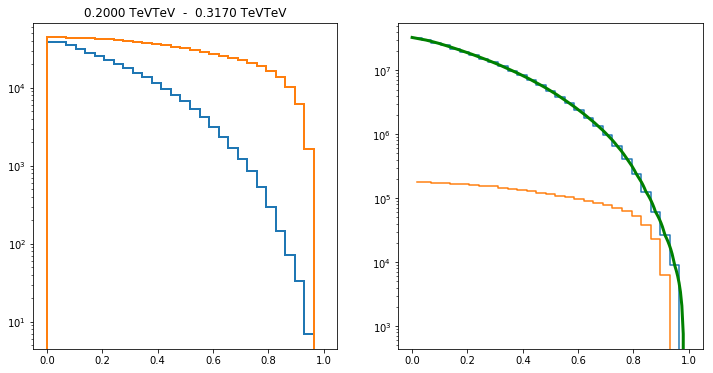

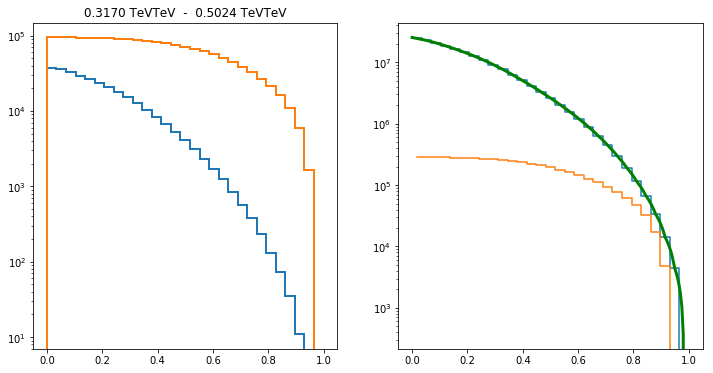

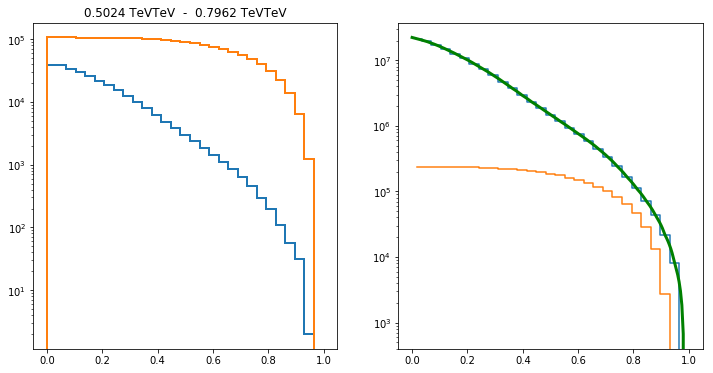

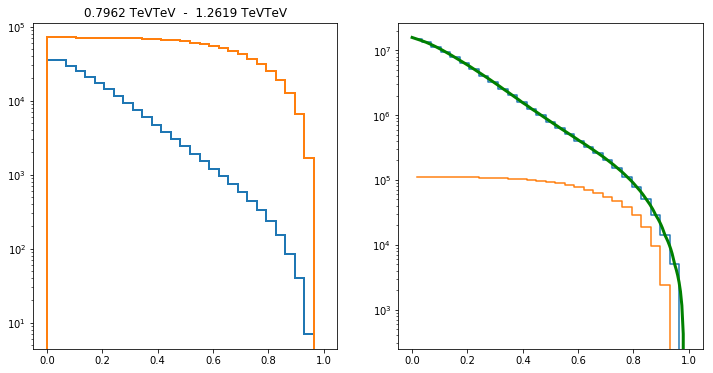

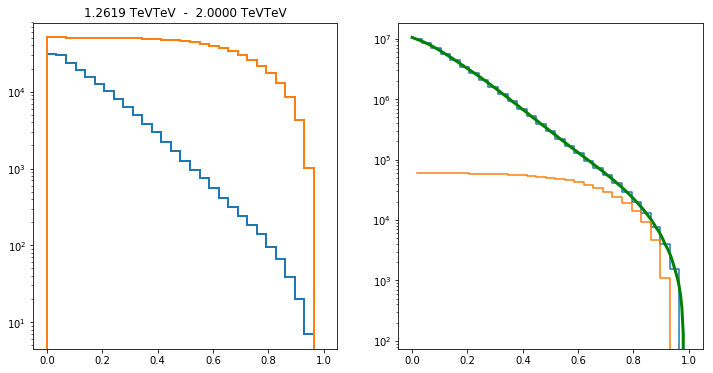

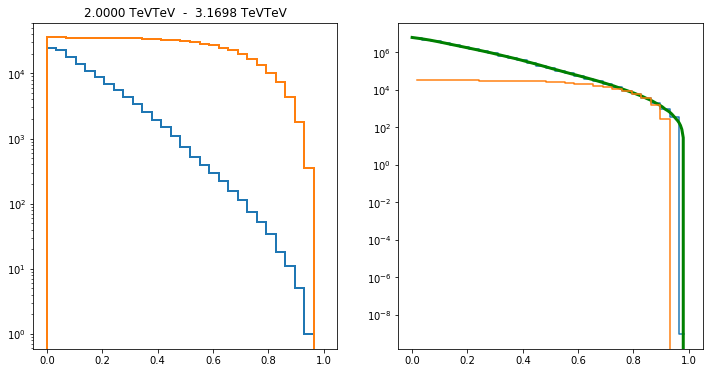

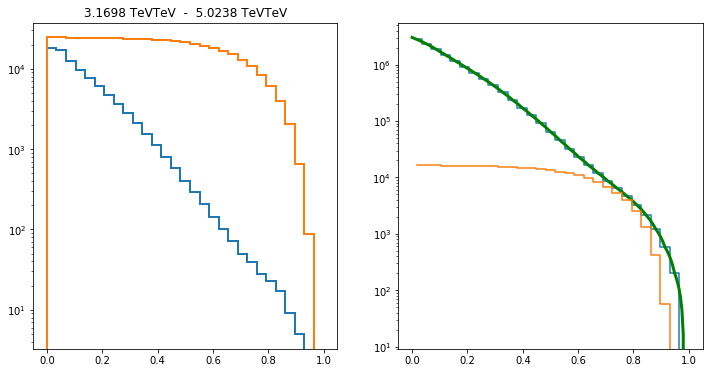

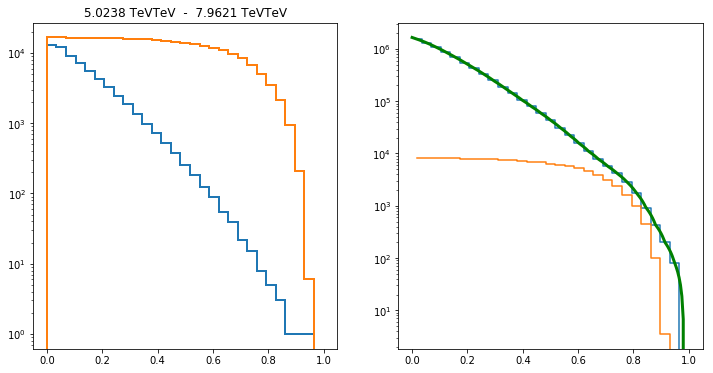

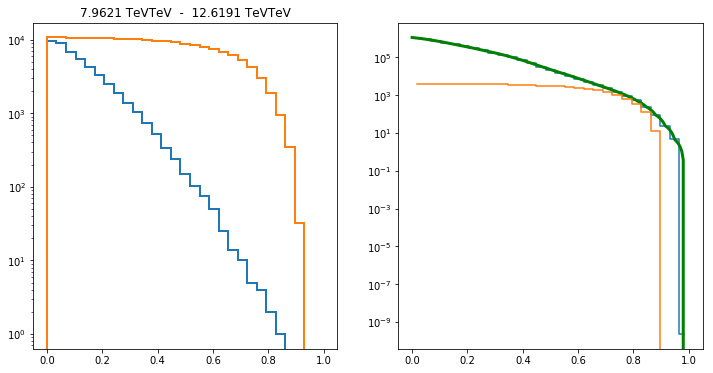

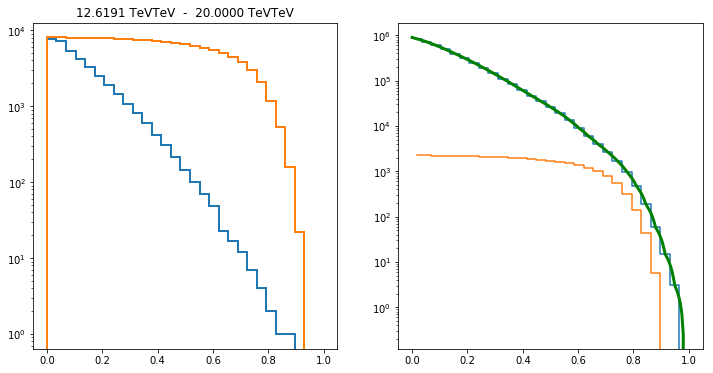

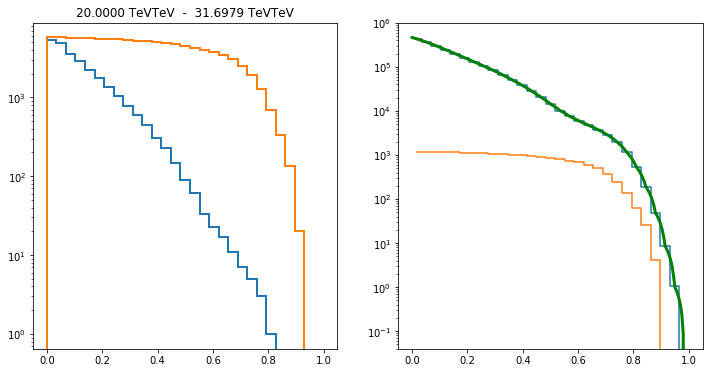

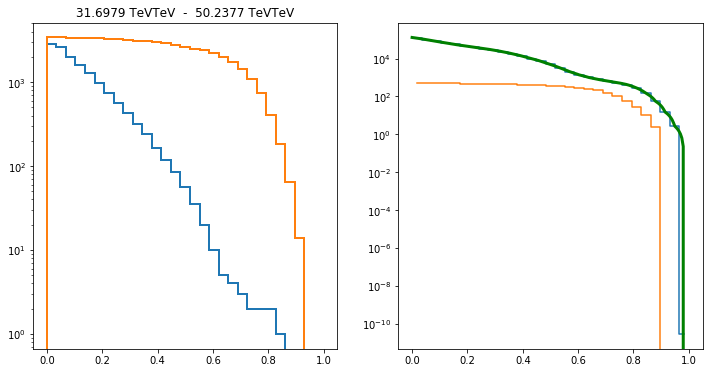

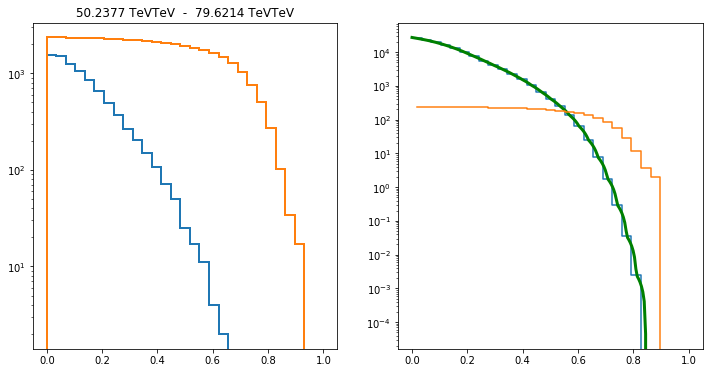

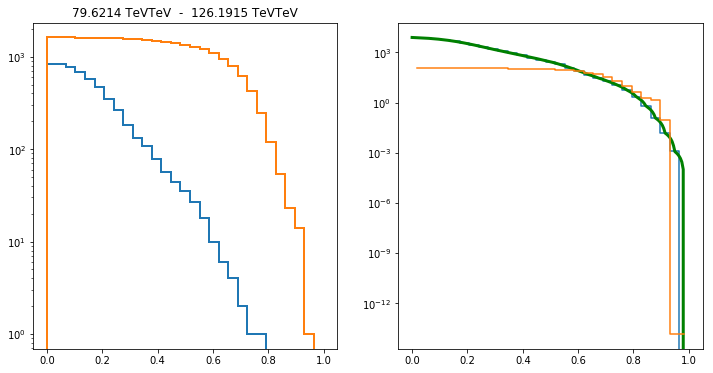

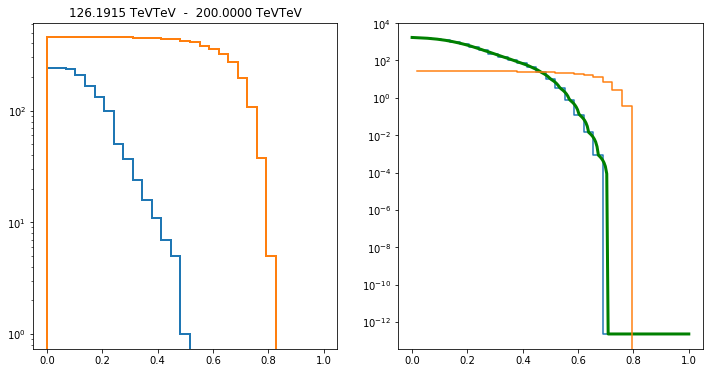

In [49]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter


c_bins = np.linspace(0, 1, 30)
c_bin_center = (c_bins[0:-1] + c_bins[1:])/2


def select_data(df, e_low, e_high):
    m = (df.gamma_energy_prediction_mean > e_low )
    m &= (df.gamma_energy_prediction_mean < e_high )
    m &= (df.theta <= 1)
    return df[m] 

ns = []
ts = []
for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
    b = select_data(protons, e_low, e_high)
    g = select_data(gammas, e_low, e_high)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title(f'{e_low:0.4f}TeV  -  {e_high:0.4f}TeV')
    ax1.hist(b.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2,  cumulative=-1)
    ax1.hist(g.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2,  cumulative=-1)
    ax1.set_yscale('log')
    
    h, _ = np.histogram(b.gamma_prediction_mean, bins=c_bins, weights=b.weight)
    h = gaussian_filter(h, sigma=1.5)
    h = np.sum(h) - np.cumsum(h)
    ax2.step(c_bin_center, h, where='mid')
    
    spl = interp1d(c_bin_center, h, kind='linear', fill_value='extrapolate')
    xs = np.linspace(0, 1, 200)
    ax2.plot(xs, spl(xs), 'g', lw=3)
    
    h, _ = np.histogram(g.gamma_prediction_mean, bins=c_bins, weights=g.weight)
    h = np.sum(h) - np.cumsum(h)
    ax2.step(c_bin_center, h, where='mid')
#     
    ax2.set_yscale('log')
        
None



/opt/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


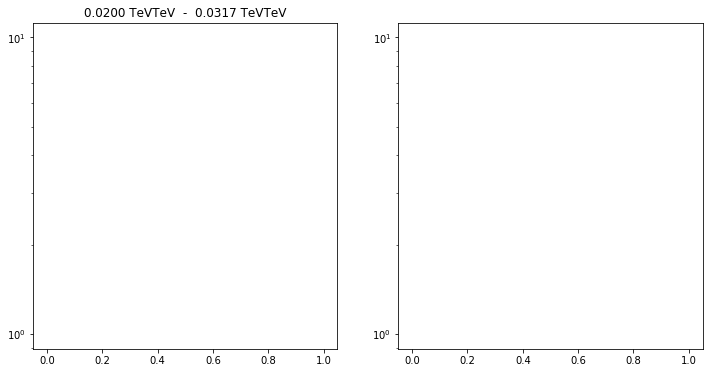

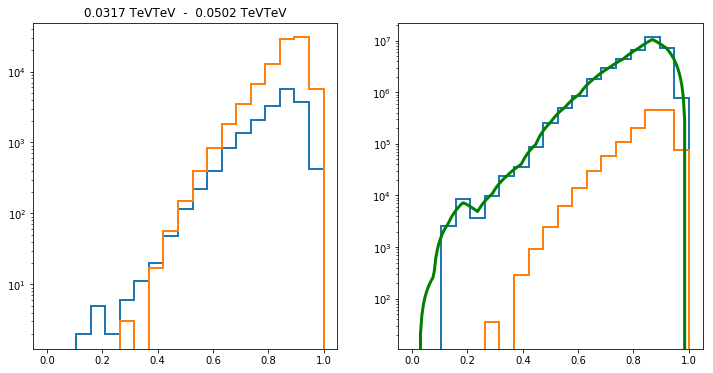

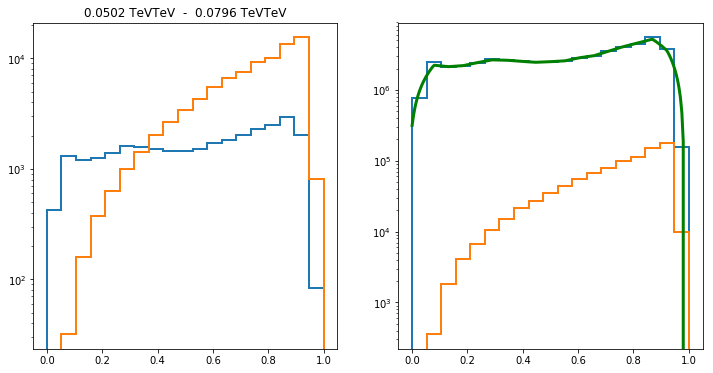

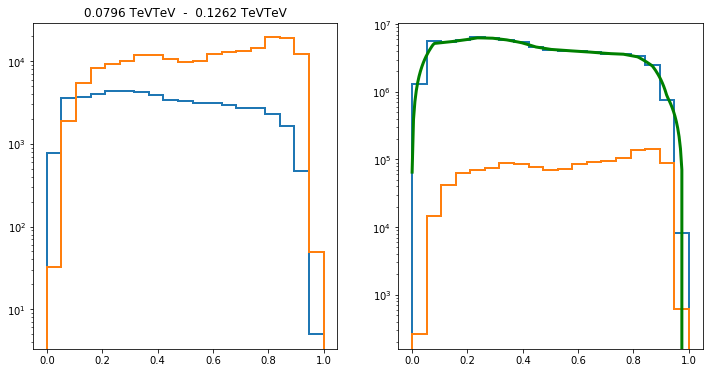

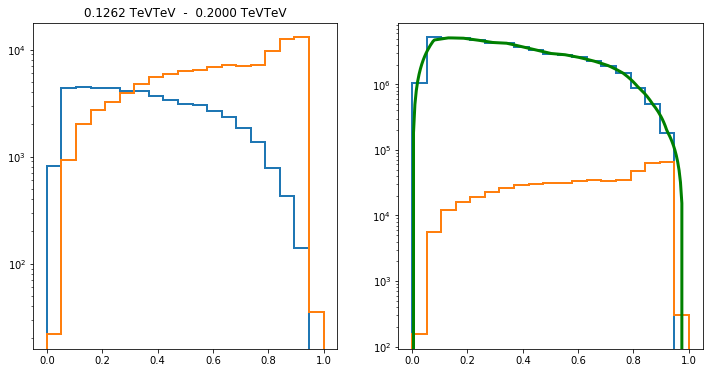

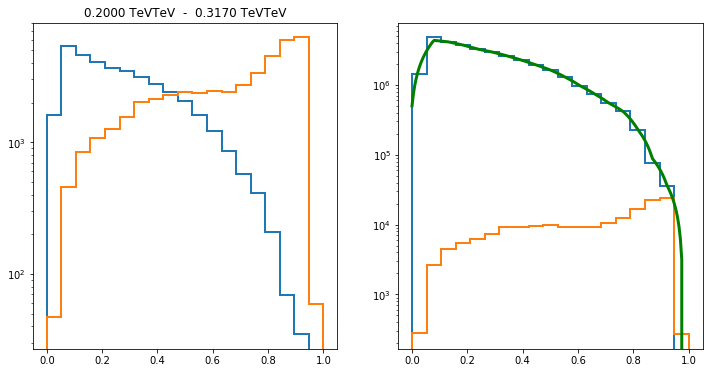

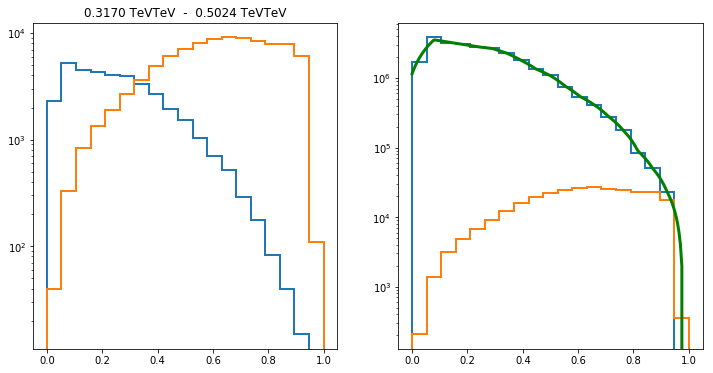

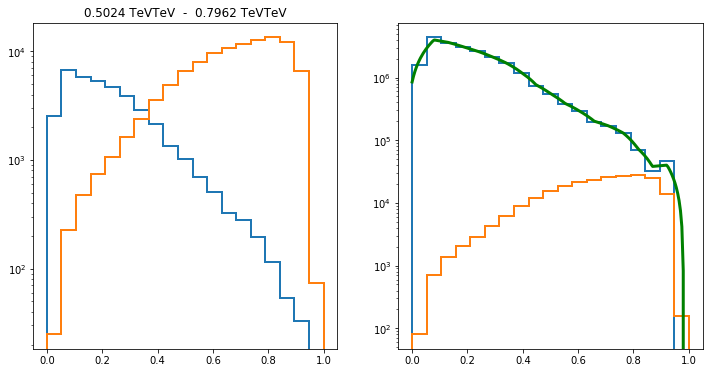

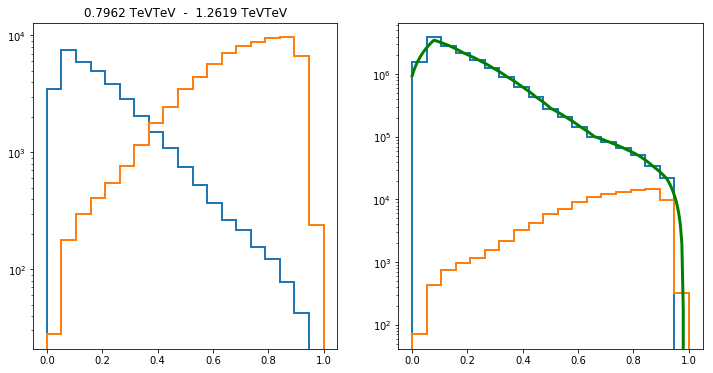

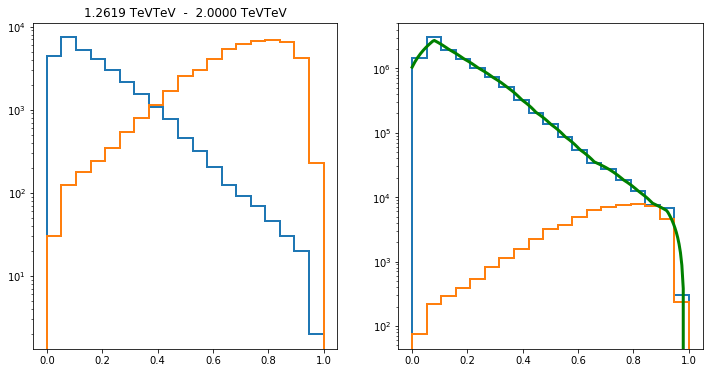

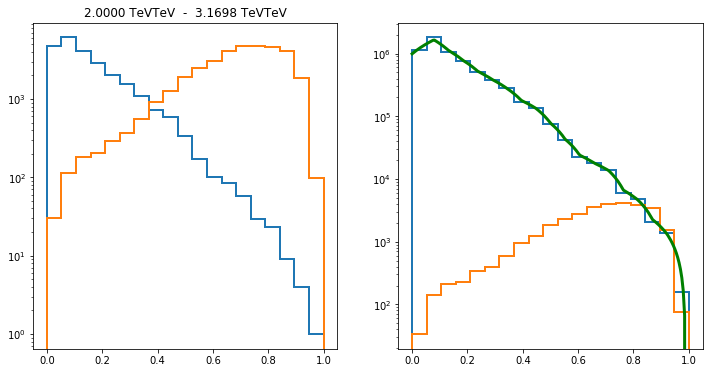

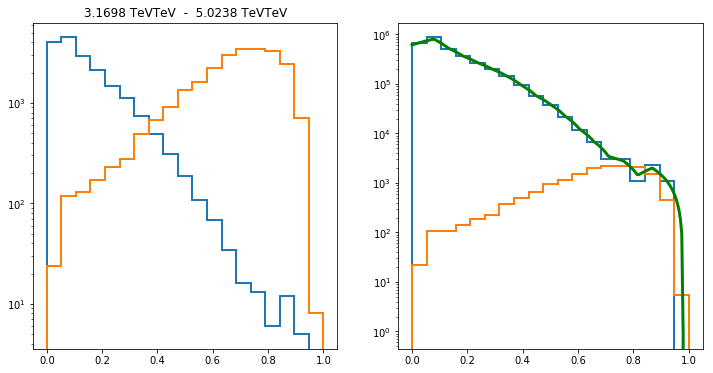

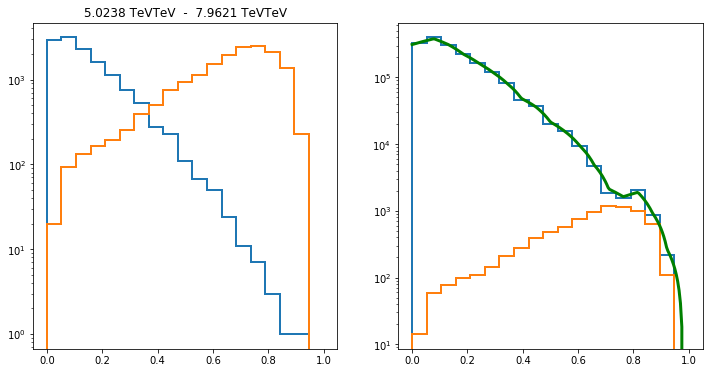

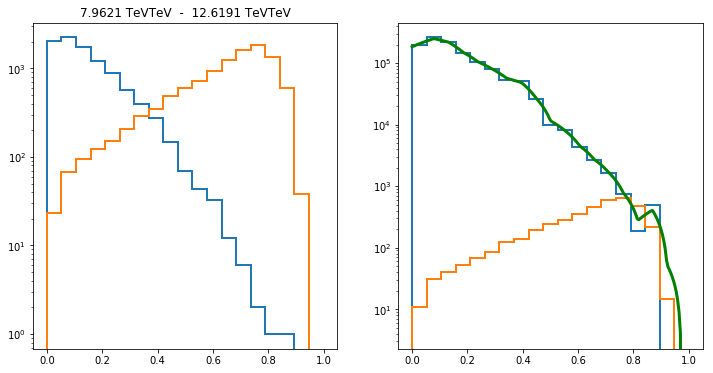

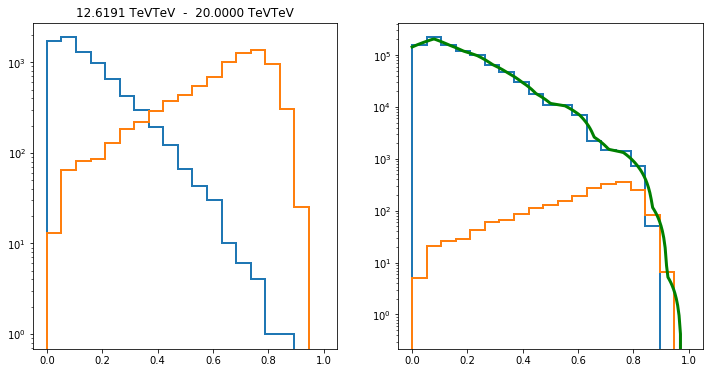

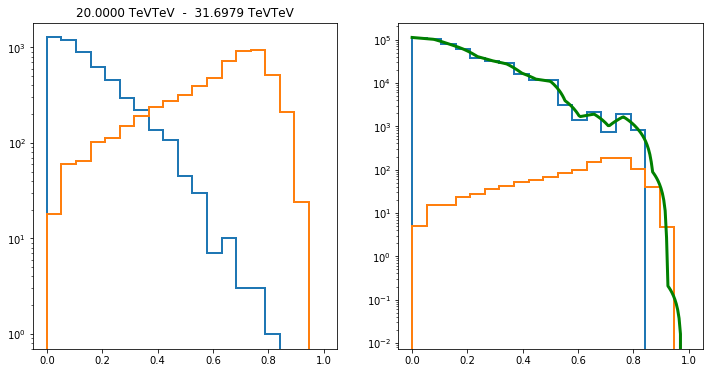

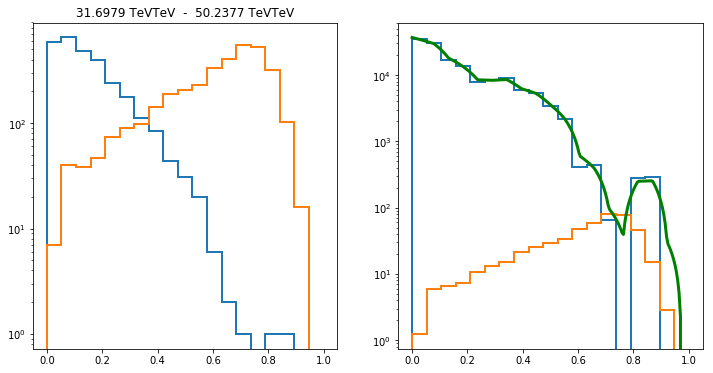

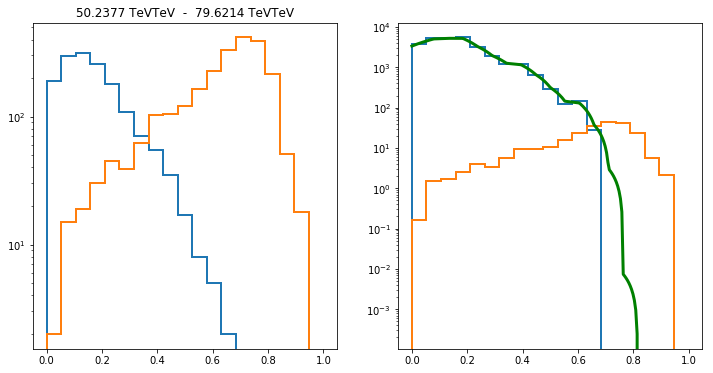

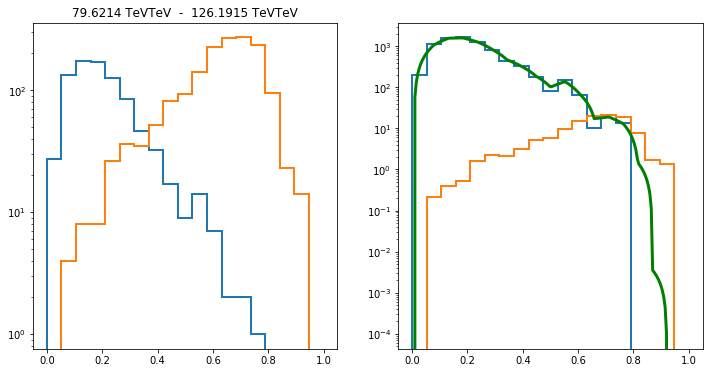

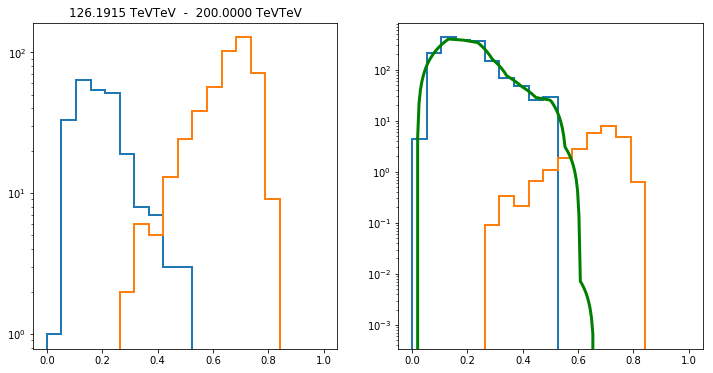

In [8]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

def select_data(df, e_low, e_high):
    m = (df.gamma_energy_prediction_mean > e_low )
    m &= (df.gamma_energy_prediction_mean < e_high )
    m &= (df.theta <= 1)
    return df[m] 

ns = []
ts = []
for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
    b = select_data(protons, e_low, e_high)
    g = select_data(gammas, e_low, e_high)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.set_title(f'{e_low:0.4f}TeV  -  {e_high:0.4f}TeV')
    ax1.hist(b.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, )
    ax1.hist(g.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, )
    ax1.set_yscale('log')
    
    h, _, _ = ax2.hist(b.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, weights=b.weight)
    ax2.hist(g.gamma_prediction_mean, bins=c_bins, histtype='step', lw=2, weights=g.weight)
    
    h = gaussian_filter(h, sigma=0.5)
    spl = interp1d(c_bin_center, h, kind='linear', fill_value='extrapolate')
    xs = np.linspace(0, 1, 200)
    
    ax2.plot(xs, spl(xs), 'g', lw=3)
    ax2.set_yscale('log')
        
None



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[   0    0    0    1    1    2    3    4    7   11   19   31   51   80
  125  188  279  403  568  782 1047 1355 1674 1947 2106 2105 1959 1754
 1609]
[ 578  613  671  735  795  847  893  932  962  982  991  992  992  996
 1009 1035 1074 1125 1187 1259 1336 1410 1463 1475 1423 1302 1134  967
  863]


/opt/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


[1543 1677 1901 2151 2376 2548 2661 2717 2720 2678 2599 2498 2389 2286
 2196 2121 2057 2000 1941 1876 1795 1687 1542 1354 1127  882  650  469
  369]
[1797 1946 2185 2431 2620 2728 2761 2740 2685 2607 2514 2410 2301 2190
 2080 1966 1843 1706 1553 1383 1201 1011  821  638  473  333  224  149
  112]
[2255 2354 2497 2608 2643 2597 2496 2368 2230 2087 1941 1790 1635 1477
 1317 1157  997  842  696  563  446  346  260  189  132   87   55   35
   25]
[2405 2491 2616 2719 2762 2737 2657 2533 2373 2182 1963 1728 1490 1260
 1048  859  694  552  433  334  252  186  133   93   62   40   25   16
   11]
[2983 3094 3248 3356 3357 3238 3023 2743 2427 2097 1773 1469 1196  962
  767  610  484  386  308  247  198  157  123   94   69   48   33   22
   17]
[3392 3450 3504 3475 3322 3053 2710 2340 1977 1643 1349 1097  887  714
  573  459  367  294  237  192  156  128  104   84   66   50   37   27
   22]
[3534 3523 3459 3292 3012 2652 2261 1883 1544 1252 1006  802  634  496
  384  295  225  171  130   99   75

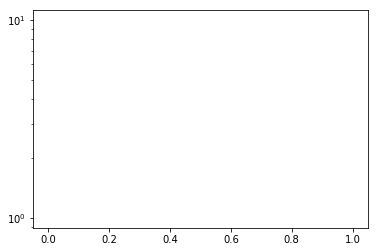

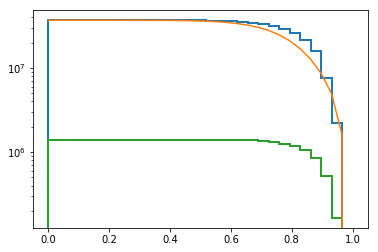

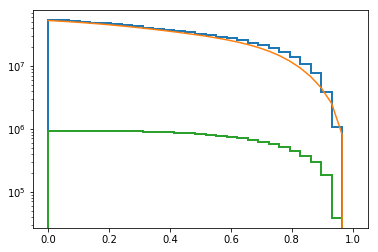

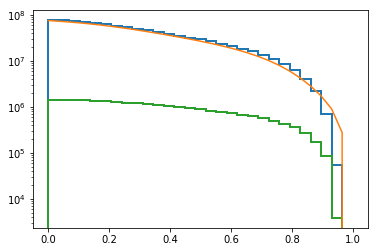

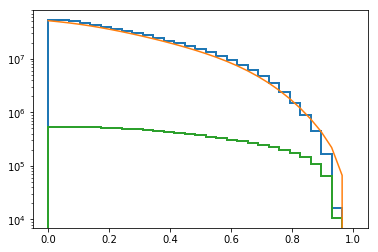

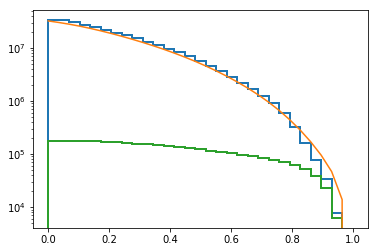

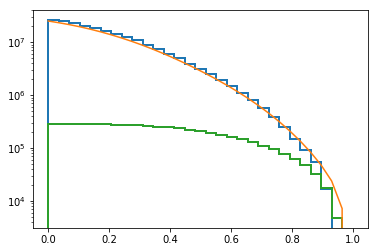

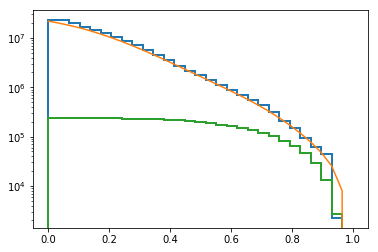

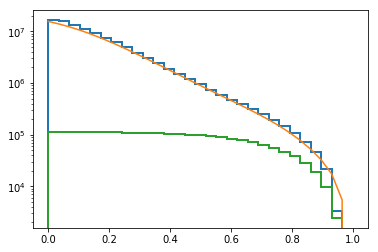

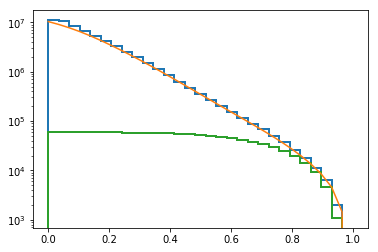

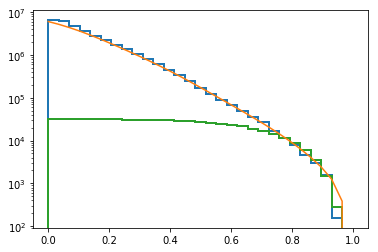

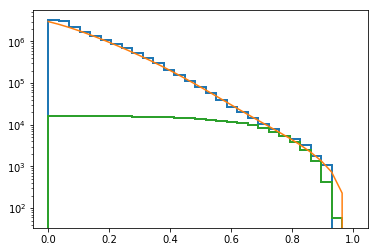

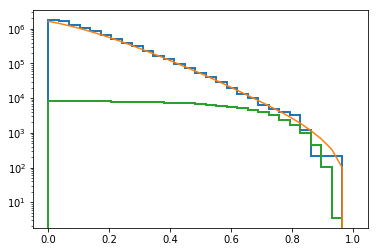

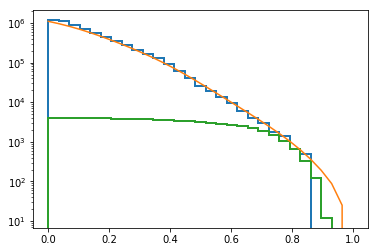

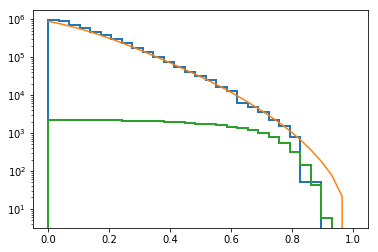

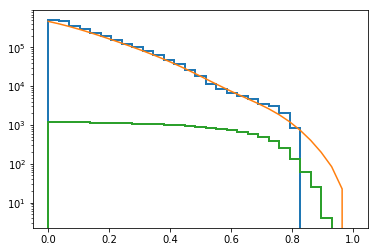

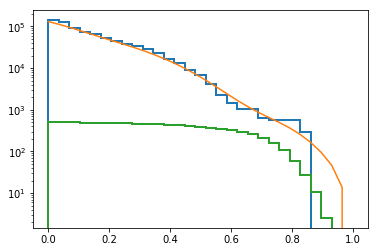

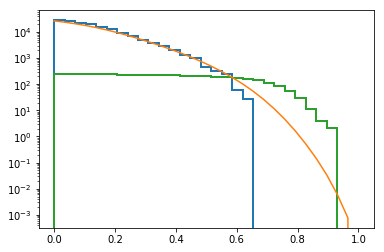

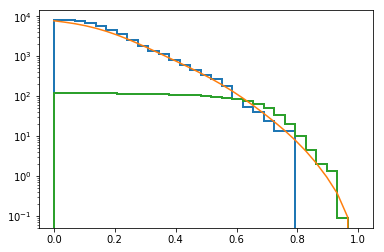

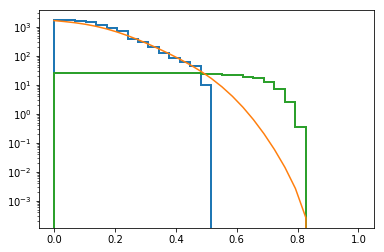

In [80]:
def select_data(df, e_low, e_high):
    m = (df.gamma_energy_prediction_mean > e_low )
    m &= (df.gamma_energy_prediction_mean < e_high )
    m &= (df.theta <= 1)
    return df[m] 


def background_estimator(df):
    c_bins = np.linspace(0, 1, 30)
    c_bin_center = (c_bins[0:-1] + c_bins[1:])/2

    df = df.query(f'theta <= 1')

    h, _ = np.histogram(df.gamma_prediction_mean, bins=c_bins, weights=df.weight)
    h = gaussian_filter(h, sigma=2.5)
    h = np.sum(h) - np.cumsum(h)
    background = interp1d(c_bin_center, h, kind=1, fill_value='extrapolate', bounds_error=False)

    
    h, _ = np.histogram(df.gamma_prediction_mean, bins=c_bins)
    h = gaussian_filter(h, sigma=2.5)
    print(h)
    h = np.sum(h) - np.cumsum(h)
    counts = interp1d(c_bin_center, h, kind=1, fill_value='extrapolate', bounds_error=False)

    return background, counts


confidences = np.linspace(0, 1, 30)
for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
    background = select_data(protons, e_low, e_high)
    b, c = background_estimator(background)
    plt.figure()
    plt.hist(background.gamma_prediction_mean, bins=confidences, cumulative=-1, weights=background.weight, histtype='step', lw=2)
    plt.plot(confidences, b(confidences))
    
    signal = select_data(gammas, e_low, e_high)
    plt.hist(signal.gamma_prediction_mean, bins=confidences, cumulative=-1, weights=signal.weight, histtype='step', lw=2)
    plt.yscale('log')
